In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

In [110]:
import osmnx as ox
gff = ox.geocoder.geocode_to_gdf('Métropole du Grand Paris (5814660)', which_result = 2)
# tag = {'railway' : True}  
t = ox.s('Paris, France', tags = tag)

In [114]:
t.railway.unique()

c:\users\g_filo01\miniconda3\envs\cityimage\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['switch', 'buffer_stop', 'stop', 'station', 'signal', 'tram_stop',
       'crossing', 'level_crossing', 'railway_crossing',
       'subway_entrance', 'train_station_entrance', 'halt',
       'platform_marker', 'tram_crossing', 'vacancy_detection',
       'emergency_subway_entrance', 'subway_exit', 'construction',
       'subway_entrance;train_station_entrance', 'subway', 'rail',
       'disused', 'tram', 'abandoned', 'razed', 'funicular',
       'narrow_gauge', 'platform', 'monorail', 'dismantled',
       'platform_edge', 'traverser', 'yes'], dtype=object)

### Preparing and cleaning the routes

In [2]:
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

In [297]:
rs = gpd.read_file('input/routesAll.shp')
dp = gpd.read_file('input/decisionPoints.shp')

In [ ]:
routes = rs.copy()
routes = routes[0:0]

for nr in range(3):
    tmp = rs[rs.routeID == nr].copy()
    tmp_dp = dp[dp.routeID == nr].copy() 
    tmp_dp = tmp_dp[(tmp_dp.nodeID != tmp.O.iloc[0] ) & (tmp_dp.nodeID != tmp.D.iloc[0] )]
    gdf = split_at_dp(tmp, tmp_dp)
    gdf.reset_index(inplace = True, drop = True)
   
    processed = []
    for r in gdf.itertuples():
        if r.Index in processed: continue
        geo = gdf.loc[r.Index].geometry
        routeChoice = gdf.loc[r.Index].routeChoic
        rc = []
        
        for rr in gdf.itertuples():
            if r == rr: continue
            elif geo == gdf.loc[rr[0]].geometry:
                other_rc = gdf.loc[rr[0]].routeChoic
                rc.append(other_rc)
                processed.append(rr.Index)
        
        if len(rc)> 0:
            rc.append(routeChoice)
            gdf.at[r.Index, 'routeChoic'] = rc
        else:
            gdf.at[r.Index, 'routeChoic'] = [routeChoice]
        
        routes = routes.append(gdf.loc[r.Index])
    routes.reset_index(inplace = True, drop = True)

In [300]:
routes['length'] = routes.geometry.length
routes['routeChoic'] = [','.join(map(str, l)) for l in routes['routeChoic']]
routes.to_file("Outputs/split.shp", driver='ESRI Shapefile')

## Import clean split routes and raw responses table

In [13]:
survey_routes = gpd.read_file("Outputs/split.shp")

In [14]:
raw = pd.read_csv("Input/resultsSurvey.csv") # raw responses
raw['startdate'] = raw.apply(lambda row: row['startdate'][11:], axis = 1)
raw['datestamp'] = raw.apply(lambda row: row['datestamp'][11:], axis = 1)
raw['duration'] = raw.apply(lambda row: compute_duration(row['startdate'], row['datestamp']), axis = 1)    
raw = raw[raw['duration']>= 20].copy()
print('nr participants '+str(len(raw)))

nr participants 220


In [15]:
# Gender
print('nr female participants '+str(len(raw[raw.PD1 == 'A2'])))
print('nr male participants '+str(len(raw[raw.PD1 == 'A1'])))
print('mean age particpants '+str(raw.PD2.mean()))

nr female participants 146
nr male participants 71
mean age particpants 25.977168949771688


In [280]:
def check_code(message):
    pos = message.find('16')
    code = message[pos:(pos+10)]
    return code
raw['code'] = raw.apply(lambda row: check_code(row['D3']), axis = 1) 

In [4]:
def compute_duration(startime, endtime):

    start = int(startime[:2])*60 + int(startime[3:5])
    end = int(endtime[:2])*60+ int(endtime[3:5])
    if end < start:
        end += (24*60)
        
    return end-start

In [16]:
vd_col = [col for col in raw if col.startswith('VD')]
to_remove = ['VD000a','VD000','VD099[SQ001]', 'VD100a', 'VD100', 'VD199[SQ001]','VD200a','VD200', 'VD299[SQ001]']
columns = ['id'] + vd_col
columns = [item for item in columns if item not in to_remove]
responses = raw[columns].copy()

In [17]:
# clean columns and prepare an easy df to read
for column in responses.columns:
    if column == 'id':
        continue
    responses.rename({column: column[2:]}, axis=1, inplace = True)
    
for column in responses.columns:
    if column == 'id':
        continue
    if ('a' in column) | ('b' in column): continue
    new_column = '-'.join(column[i:i+3] for i in range(0, len(column), 3))
    responses.rename({column: new_column}, axis=1, inplace = True)
    
responses.rename({'150a151152': '150a-151-152'}, axis=1, inplace = True)
responses.rename({'150b126': '150b-126'}, axis=1, inplace = True)

In [18]:
route_models = ['DS','AC', 'DR', 'DRB', 'DL', 'DLG', 'DG', 'AR', 'ARB', 'AL', 'ALG', 'AG', 'TS']
summary = pd.DataFrame(columns = ['id']+list(survey_routes.video.unique()))
del summary[None]

summary = summary.reindex(sorted(summary.columns), axis=1)

for row in responses.itertuples():
    sectors = responses.loc[row.Index].notna().dot(responses.columns+',').rstrip(',')
    sectors = sectors.replace('-', ',')
    sectors_list = sectors.strip('').split(',')
    for sector in sectors_list:
        summary.at[row.Index, sector] = 1
        summary.at[row.Index, 'id'] = responses.loc[row.Index].id
        
summary.drop('114', inplace = True, axis = 1)
summary.fillna(0, inplace = True)
for column in summary.columns: 
    summary.rename(columns={column: str(column)}, inplace = True)

In [19]:
video0 = [col for col in summary if col.startswith('0')]
video1 = [col for col in summary if col.startswith('1')]
video2 = [col for col in summary if col.startswith('2')]
videos = [video0, video1, video2]

In [20]:
survey_routes['routeChoice'] = survey_routes.apply(lambda row: row['routeChoic'].replace(" ",""), axis = 1)
survey_routes['routeChoice'] = survey_routes.apply(lambda row: row['routeChoice'].strip('][').split(','), axis = 1)
survey_routes.drop('routeChoic', inplace = True, axis =1)

In [35]:
route_stats = pd.DataFrame(index = summary['id'], columns = route_models)
for row in summary.itertuples():
    set_route_stats(summary, row.Index, survey_routes)

## Computing statistics

In [47]:
route_stats['usingRegions'] = (route_stats['DR']+route_stats['DRB']+ route_stats['AR']+route_stats['ARB'])
route_stats['usingLocal'] = (route_stats['DL']+route_stats['AL'] + route_stats['DLG']+route_stats['ALG'])
route_stats['usingGlobal'] = (route_stats['DG']+route_stats['AG']+ route_stats['DLG']+route_stats['ALG'])
route_stats['distance'] = (route_stats['DS']+route_stats['DR']+ route_stats['DRB']+route_stats['DLG'] + route_stats['DL'] 
                     + route_stats['DG'])
route_stats['angularChange'] = (route_stats['AC']+route_stats['AR']+ route_stats['ARB']+route_stats['ALG'] + route_stats['AL'] 
                     + route_stats['AG'])
route_stats['topological'] = route_stats['TS']

In [34]:
def split_at_dp(gdf, dp):
    old_gdf = gdf.copy()
    
    for row in tmp.itertuples():
        line_geometry = gdf.loc[row.Index].geometry
        union = dp.unary_union
        intersections = line_geometry.intersection(union)
        if intersections.geom_type == 'Point': 
            intersections = [intersections]

        points = [i for i in intersections if i.geom_type == 'Point']
        new_collection = []

        for p in points:
            if (p.coords[0] == line_geometry.coords[0]) | (p.coords[0] == line_geometry.coords[-1]): 
                pass # disregarding the ones which lie on the line's u-v nodes
            else: new_collection.append(p) # only checking the others
        if len(new_collection) == 0: 
            continue    

        geometry_collection = MultiPoint([point.coords[0] for point in new_collection])  
        # including the intersecting geometries in the coordinates sequence of the line and split
        new_line_geometries = ci.split_line_at_MultiPoint(line_geometry, geometry_collection) 
        len(new_line_geometries)

        for n, line in enumerate(new_line_geometries): # assigning the resulting geometries
            if n == 0: 
                index = row.Index
            else: index = max(gdf.index)+1
            # copy attributes
            gdf.loc[index] = gdf.loc[row.Index]  
            # and assign geometry an new edgeID 
            gdf.at[index, 'geometry'] = line

    return gdf


def set_route_stats(summary_responses, index, survey_routes):
        
    routes = []

    for video in videos:
        route_composition = dict((rC, 0.0) for rC in route_models)
        
        sections = summary_responses.loc[index][video][summary_responses.loc[index][video] != 0].index.values
        traversed = survey_routes[survey_routes.video.isin(sections)]
        total_length = traversed.length.sum()
        tmp = traversed.routeChoice
        route_models_tmp = list(set([item for sublist in tmp for item in sublist]))
        if 'not' in route_models_tmp:
            route_models_tmp.remove('not')
        complete = []
        
        # check complete
        for rC in route_models_tmp:
            in_all = True
            for l in tmp:
                if rC not in tmp:
                    in_all = False
                    break
            if in_all:
                complete.append(rC)
        
        if len(complete) != 0:
            for rC in complete:
                route_composition[rC] = float("{0:.2f}".format(rC/len(complete)))
        else:
            for rC in route_models_tmp:
                for row in traversed.itertuples():
                    rC_section = traversed.loc[row.Index].routeChoice
                    if rC in rC_section:
                        value = float("{0:.2f}".format(traversed.loc[row.Index].length/total_length/len(rC_section)))
                        route_composition[rC] += value
        
        routes.append(route_composition)

    final_composition = dict((rC, 0.0) for rC in route_models) 
    for key,_ in final_composition.items():
        final_composition[key] = float("{0:.2f}".format((routes[0][key]+routes[1][key]+routes[2][key])/3))
        subject = summary_responses.loc[index].id
        route_stats.loc[subject][key] = final_composition[key]
        

In [50]:
route_stats_tmp['usingRegions'].mean()

0.2973181818181818

## Cluster Analysis

In [51]:
#libraries

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

In [52]:
route_stats

,DS,AC,DR,DRB,DL,DLG,DG,AR,ARB,AL,ALG,AG,TS,usingRegions,usingLocal,usingGlobal,distance,angularChange,topological
id,,,,,,,,,,,,,,,,,,,
9,0.05,0.02,0.03,0.1,0.0,0.09,0.25,0.03,0.1,0.03,0.03,0.06,0.18,0.26,0.15,0.43,0.52,0.27,0.18
10,0.07,0.05,0.03,0.1,0.04,0.16,0.19,0.02,0.09,0.03,0.01,0.08,0.15,0.24,0.24,0.44,0.59,0.28,0.15
13,0.05,0.06,0.04,0.11,0.04,0.01,0.11,0.05,0.12,0.05,0.07,0.1,0.17,0.32,0.17,0.29,0.36,0.45,0.17
14,0.07,0.03,0.07,0.17,0.02,0.12,0.08,0.08,0.15,0.06,0.04,0.07,0.06,0.47,0.24,0.31,0.53,0.43,0.06
15,0.05,0.05,0.04,0.01,0.04,0.04,0.37,0.03,0.01,0.05,0.05,0.07,0.22,0.09,0.18,0.53,0.55,0.26,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,0.07,0.04,0.04,0.11,0.09,0.14,0.03,0.04,0.11,0.06,0.04,0.07,0.15,0.3,0.33,0.28,0.48,0.36,0.15
468,0.03,0.21,0.01,0.01,0.09,0.13,0.02,0.02,0.02,0.16,0.13,0.17,0.01,0.06,0.51,0.45,0.29,0.71,0.01
469,0.02,0.11,0.05,0.05,0.12,0.14,0.09,0.05,0.04,0.08,0.08,0.03,0.12,0.19,0.42,0.34,0.47,0.39,0.12


In [68]:
# def with variable object of interest
def standardisation(df):
    df = df.copy()
    for column in df.columns:
        df[column] = (df[column]-df[column].mean())/df[column].std()
    return df
def log_transf(df):
    
    df = df.copy()
    for column in df.columns:
        df[column] = np.log(df[column])
    return df


route_stats_tmp = route_stats[['usingRegions','usingLocal','usingGlobal', 'distance', 'angularChange']].copy()
route_stats_tmp = route_stats_tmp.astype(float)
route_stats_tmp.index.name = None
X = standardisation(route_stats_tmp)
X_log = log_transf(route_stats_tmp)

In [58]:

from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import LinearSegmentedColormap, DivergingNorm
import mapclassify

<Figure size 720x1008 with 0 Axes>

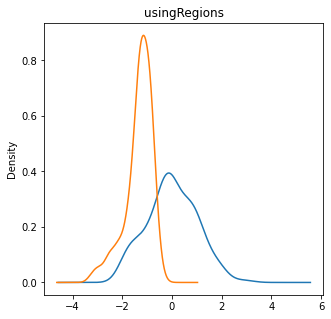

<Figure size 720x1008 with 0 Axes>

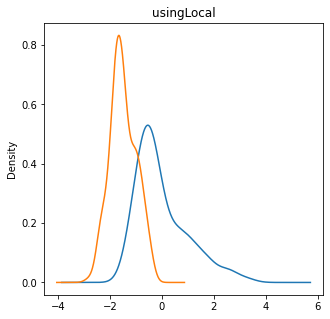

<Figure size 720x1008 with 0 Axes>

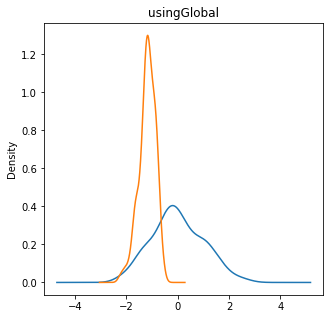

<Figure size 720x1008 with 0 Axes>

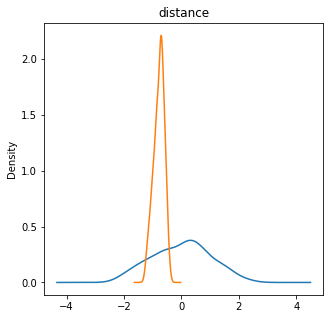

<Figure size 720x1008 with 0 Axes>

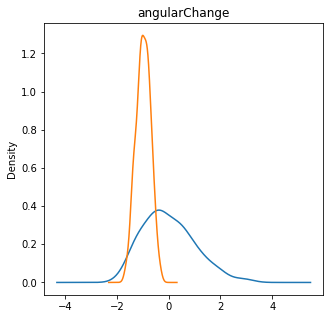

In [81]:
for s in X.columns:
    figsize = (10, 14)
    fig = plt.figure(figsize=figsize)

#     grid = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad= (0.50, 1.00))
#     for n, ax in enumerate(grid):
#         ax.set_aspect("equal")
#         if (n == 0):
#             X[s].plot.kde(ax = ax)
#         else:
#             X_log[s].plot.kde(ax = ax)
    fig, ax = plt.subplots(1, figsize=(5,5))
    ax =  X[s].plot.kde()
    ax =X_log[s].plot.kde()
    ax.set_title(s)


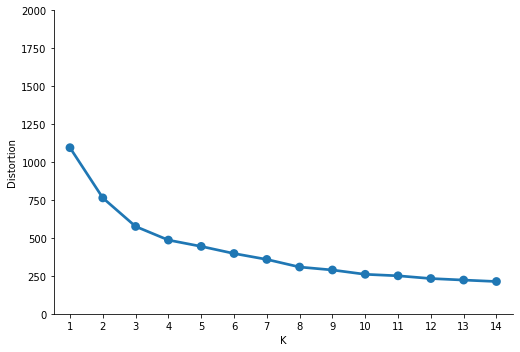

In [27]:
distortions = []
for i in range(1,15):
    km = KMeans(n_clusters=i, init ='k-means++', n_init=1, max_iter=300, random_state= 0)
    km.fit(X)
    distortions.append(km.inertia_)

distortions = pd.DataFrame({'Distortion': distortions, 'K':list(range(1,15))})

elbow = sns.factorplot(x='K', y='Distortion', data=distortions, size=4.75, aspect=1.5)
elbow.set(ylim=(0, 2000))

For n_clusters = 2 The average silhouette_score is : 0.3106028644500111
For n_clusters = 3 The average silhouette_score is : 0.21551842756406958
For n_clusters = 4 The average silhouette_score is : 0.23948953433102022
For n_clusters = 5 The average silhouette_score is : 0.22599820559853476
For n_clusters = 6 The average silhouette_score is : 0.21341053296892457


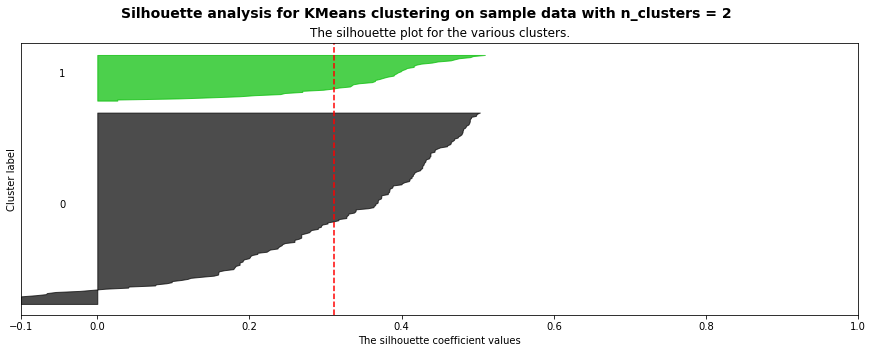

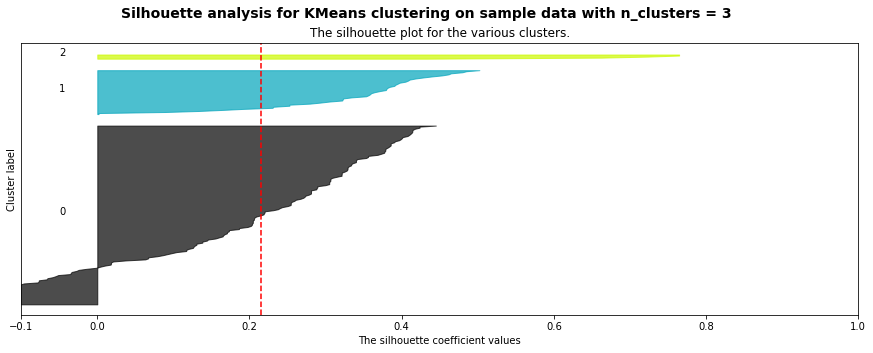

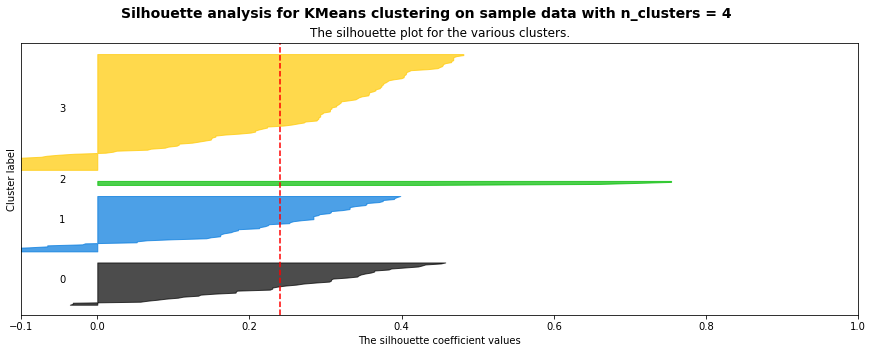

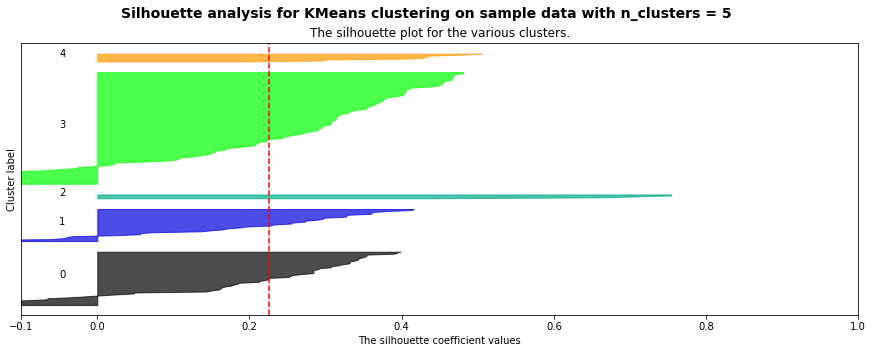

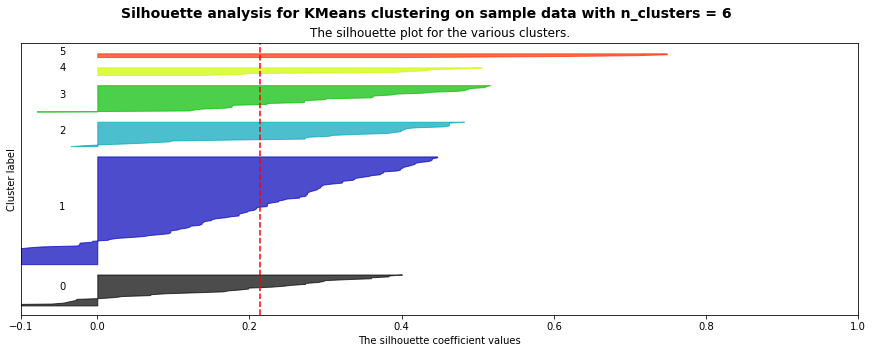

In [28]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(figsize=(15,5))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10]) 
    


    clustering = AgglomerativeClustering(n_clusters= n_clusters, affinity='euclidean', linkage='average').fit(X)
    labels = clustering.labels_
    
    silhouette_avg = silhouette_score(X , labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, 
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.39591539453284547
For n_clusters = 3 The average silhouette_score is : 0.3633990362332988
For n_clusters = 4 The average silhouette_score is : 0.33081923644520245
For n_clusters = 5 The average silhouette_score is : 0.3363583699848423
For n_clusters = 6 The average silhouette_score is : 0.3584793454806447


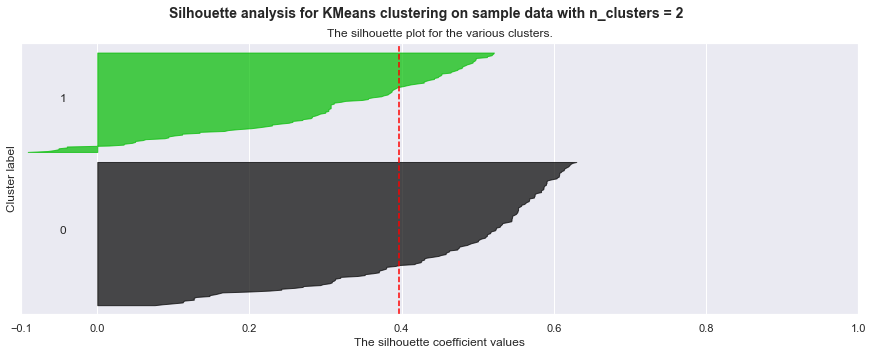

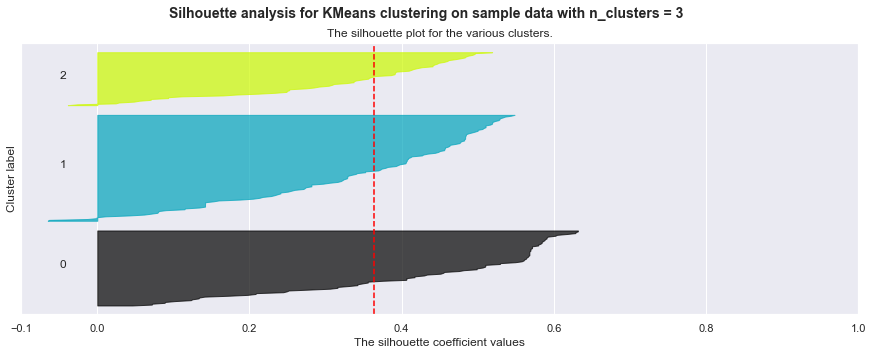

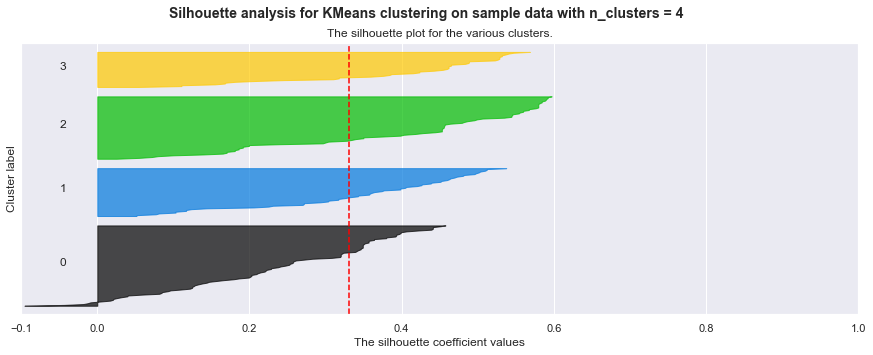

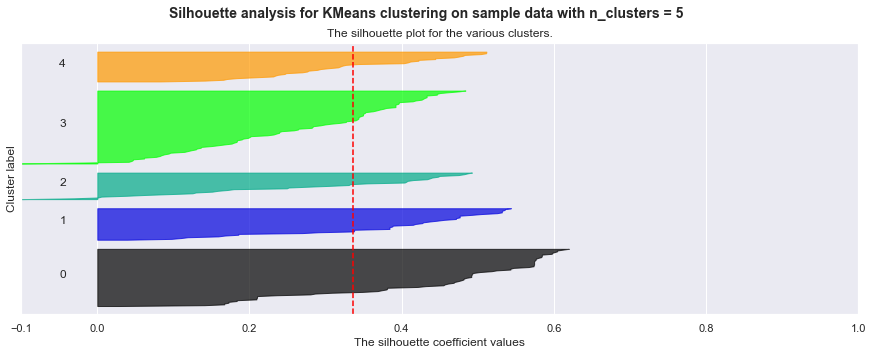

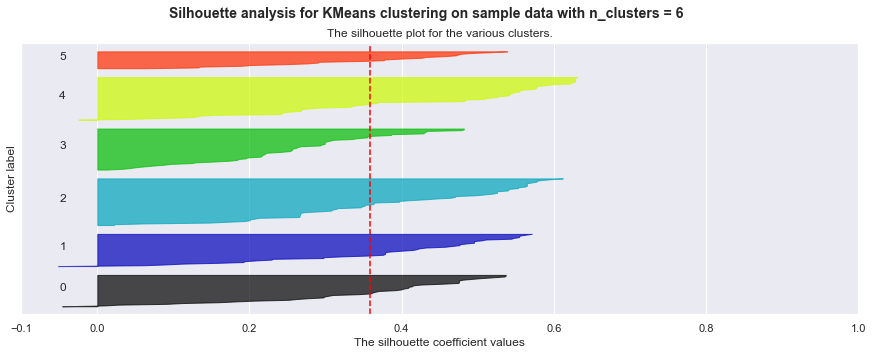

In [183]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(figsize=(15,5))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10]) 
    
    kmeans = KMeans(n_clusters= n_clusters, n_init = 100, init ='k-means++', max_iter = 1000, 
                    random_state=1, algorithm = 'full').fit(X)
    labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(X , labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, 
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [184]:
kmeans = KMeans(n_clusters=3, init ='k-means++', max_iter = 1000, random_state=0).fit(X)
labels_k = kmeans.labels_

route_stats_tmp['group']=labels_k #assigning cluters
means = route_stats_tmp.groupby(by = ['group']).mean()
means.index.name = None

[(0.0, 0.8)]

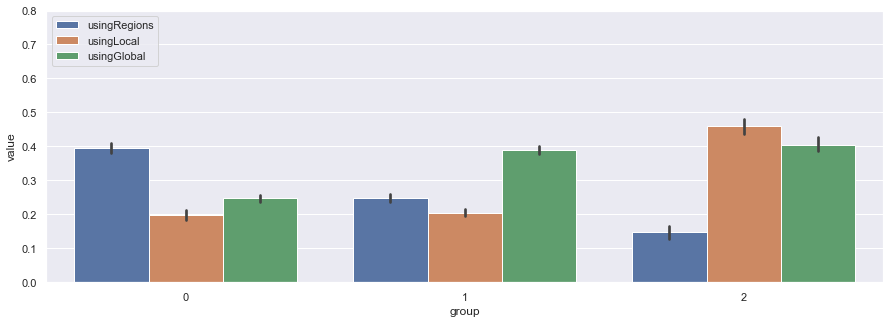

In [185]:
tidy = route_stats_tmp.melt(id_vars='group')
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x='group', y='value', hue='variable', data=tidy)
plt.legend(loc='upper left')
ax.set(ylim=(0.0, 0.8))

In [241]:
X['distance'].corr(X['angularChange'])

-0.617032520589065

In [235]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.38331344 0.33859333 0.20266584 0.05678012 0.01467123]


In [225]:
from sklearn_extensions.fuzzy_kmeans import FuzzyKMeans
fuzzy_kmeans = FuzzyKMeans(k=3, m=2).fit(X)

ModuleNotFoundError: No module named 'sklearn.datasets.samples_generator'

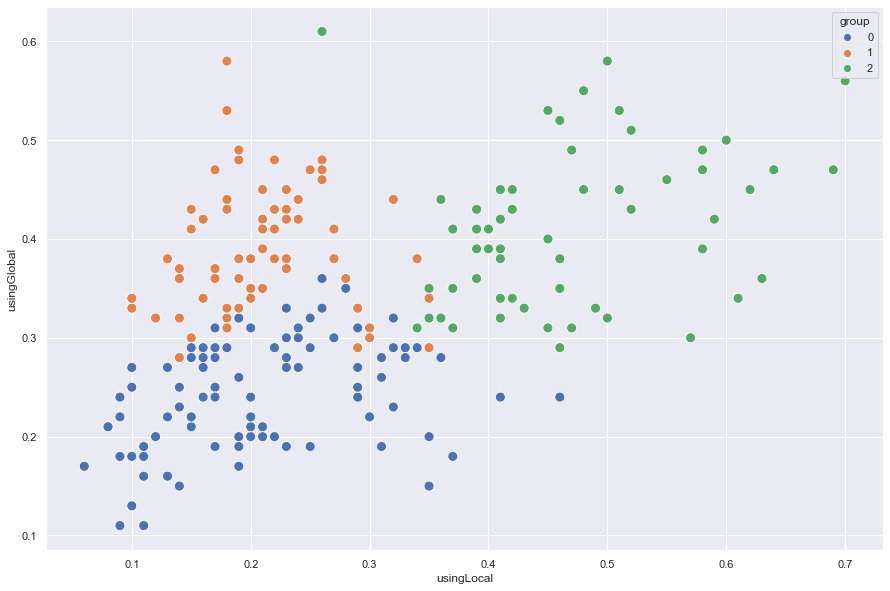

In [187]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.scatterplot(data=route_stats_tmp, x="usingLocal", y="usingGlobal", hue="group", palette="deep", s = 100)